# 1 实现功能

## 1.1 订阅机制
在主页面点击“新增订阅”，进入订阅页面。订阅界面支持以下几种订阅方式：
- 诗人订阅：用户输入一个数据库中的诗人名，订阅该诗人的所有诗
- 关键词订阅：用户输入关键词，订阅匹配到关键词的诗句。如果输入多个关键词，那么将订阅每个关键词的订阅取并集。如果输入的关键词是高频词（频数大于10），则进行模糊匹配，订阅关键词及其近义词匹配到的诗。
- 混合订阅：同时输入诗人名和关键词，则会订阅诗人订阅和关键词订阅的交集。
如果不输入诗人名和关键词，订阅将失败。

## 1.2 展示机制
订阅完成后，将刷新主界面，此时可以点击已有订阅查看订阅内容。查看页面用`tkinter.ttk.Notebook`实现，支持按`Ctrl-Tab`和`Shift-Ctrl-Tab`前后翻页，或者直接选取指定页面。页面中每个关键词用黄色高亮，每个近义词用青色高亮。

页面显示的诗歌按照如下规则加权，根据权重大小从高到低排序：
- 每首诗的初始权重为0
- 如果诗歌包含关键词，则权重+1
- 如果诗歌包含近义词，则所加权重为该近义词与原关键词的相似度
因此，如果是单关键词订阅，该算法实现了按置信度排序；如果是多关键词订阅，则优先返回匹配关键词最多的诗歌。



# 2 TF-IDF特征提取和近义词挖掘算法描述

## 2.1 TF-IDF特征提取
这一部分的代码可以参考`poem_database.ipynb`中`PoemDatabase.cal_tfidf()`的部分。

- 首先，对文档进行分词，得到new_table
- 根据分词得到每个单词的倒排索引invertidx，对每个倒排索引求长度后，可求出inverted document frequency矩阵，维度为（wordlist长度，1）
- 对new_table做分组操作，从而得到（poem_id, term, frequency）三元组列表，这种形式很容易用`scipy.sparse.coo_sparse`建立term frequency稀疏矩阵，维度为（wordlist长度，poem总数）
- tf矩阵和idf矩阵相乘（broadcasting），得到tfidf矩阵$F$

需要说明的是，作业要求中指明需要输出tfidf结果，但是csv文件输出结果过大，excel文件在我电脑上爆内存了，所以用scipy.sparse库直接把稀疏矩阵保存下来了。如有必要可以用这个库将其打开。

## 2.2 近义词挖掘算法
基于假设“相似的词具有相似的上下文语境”，我们提取tfidf矩阵的行向量作为词向量，并用词向量的余弦相似度量两个词的作为近义词的可能性。则有：
$$
\text{sim}(w_i, w_j) = \cos(<v_i, v_j>) = \dfrac{|v_i \cdot v_j|}{|v_i|\cdot|v_j|}
$$
这一结果还可以继续简化。设$L = (\dfrac{1}{|v_1|}, \cdots, \dfrac{1}{|v_n|})^T$，于是得到相似矩阵$S = (\text{sim}(w_i, w_j)) = (LL^T) \otimes (FF^T)$。这样后续考察一个关键词的近义词时，只需提取相似矩阵中对应的一行即可。在计算过程中，我们的词向量考虑了所有出现的单词；但考察近义词时，我们只需考虑频度大于10的那些词就可以了，在计算上只需提取相似矩阵的一个子矩阵$S^*$即可。


# 3 关键词扩展前后结果对比分析
下文中，黄色高亮对应原始关键词，青色高亮对应新匹配的近义词

关键词扩展能够捕捉到语义相近的单词
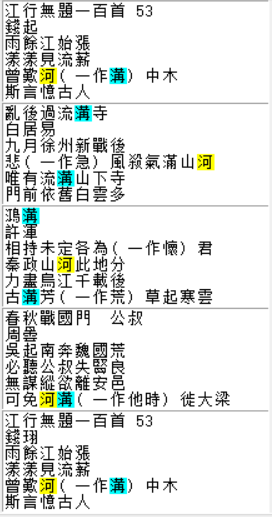
关键词扩展还能捕捉到涉及同一话题的单词（因为我们取的上下文窗口比较大）
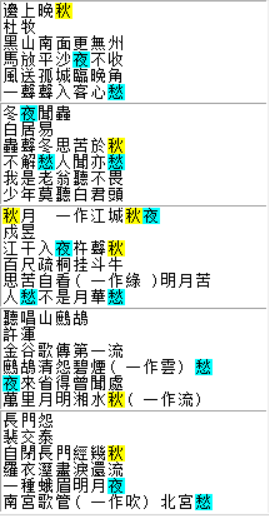

# 4 加分项实现
## 4.1 近义词评价机制

C:\Users\45887\AppData\Local\conda\conda\envs\torch\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
<string>:96: RuntimeWarning: divide by zero encountered in reciprocal


只考虑相似度在(0, 1)的高频词对，即那些可能成为近义词的词
先看一下整体情况


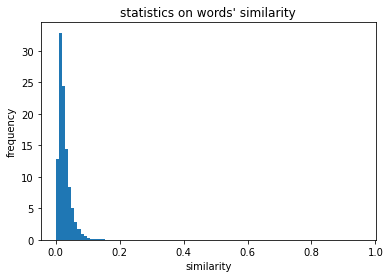

绝大部分词的相似度小于0.2。暂时忽略相似度大于0.2的词对是合理的


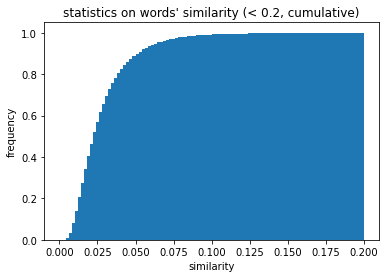

取相似度阈值为0.1，则两个词的相似度超过了99%的相似词对，我们认为这样的词对是近义词
取如此高的阈值，主要是为了选取适当数目的近义词，尽量控制在个位数范围内
接下来核实匹配比例，并对近义词匹配数量的期望进行统计
Similar word-pair proportion: 0.00984452431133716
Expected similar word number: 3.0938266102072656 
平均每个词会匹配到3个左右近义词，是一个理想的比例
对于那些近义词数量较多的，我们最终只取相似度最高的前三个；对于近义词数量较少的，我们就不取了


In [2]:
import import_ipynb
from poem_database import PoemDatabase
poem_db = PoemDatabase()
poem_db.evaluate_similarity()
# 代码的warning并不影响运行